<a href="https://colab.research.google.com/github/lukplamino/DADS7202_HW02-CNN_MNLP_Group/blob/main/InceptionV3_No_Fine_Tuning_MNLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# List all NVIDIA GPUs as avaialble in this computer (or Colab's session)
!nvidia-smi -L

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [3]:
import os
import sys
import numpy as np
import pandas as pd
import random as rn
import sklearn
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from IPython.display import Image, display
import matplotlib.cm as cmp
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
print( f"Python {sys.version}\n" )
print( f"NumPy {np.__version__}\n" )
%matplotlib inline
print(f'The scikit-learn version is {sklearn.__version__}')
print( f"TensorFlow {tf.__version__}" )
print( f"tf.keras.backend.image_data_format() = {tf.keras.backend.image_data_format()}" )
gpus = tf.config.list_physical_devices('GPU')
print( f"TensorFlow detected { len(gpus) } GPU(s):" )
for i, gpu in enumerate(gpus):
  print( f".... GPU No. {i}: Name = {gpu.name} , Type = {gpu.device_type}" )

Python 3.7.15 (default, Oct 12 2022, 19:14:55) 
[GCC 7.5.0]

NumPy 1.21.6

The scikit-learn version is 1.0.2
TensorFlow 2.9.2
tf.keras.backend.image_data_format() = channels_last
TensorFlow detected 0 GPU(s):


In [5]:
np.random.seed(123)
tf.random.set_seed(456)
rn.seed(789)

# **Load Data**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
#0 = Lady_Finger_Banana, 1 = Cavendish_Banana, 2 = Cultivated_Banana

x0 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Lady_Finger_Banana.npy')
x1 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cavendish_Banana.npy')
x2 = np.load('/content/drive/My Drive/DADS7202_HW2_CNN/npy/x_Cultivated_Banana.npy')

print(x0.shape)
print(x1.shape)
print(x2.shape)

(200, 224, 224, 3)
(200, 224, 224, 3)
(200, 224, 224, 3)


In [8]:
y0 = np.array([0 for i in range(200)])
y1 = np.array([1 for i in range(200)])
y2 = np.array([2 for i in range(200)])

print(y0.shape)
print(y1.shape)
print(y2.shape)

(200,)
(200,)
(200,)


In [9]:
x = np.concatenate((x0, x1, x2))
y = np.concatenate((y0, y1, y2))
print(x.shape)
print(y.shape)

(600, 224, 224, 3)
(600,)


In [10]:
#Train Test Split
from sklearn.model_selection import train_test_split

test_size = 0.3
x_train, x_test = train_test_split(x, test_size = test_size, random_state = 3)
y_train, y_test = train_test_split(y, test_size = test_size, random_state = 3)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(420, 224, 224, 3)
(420,)
(180, 224, 224, 3)
(180,)


In [11]:
# #visualize the first 5 image
label = ['Lady Finger Banana','Cavendish Banana','Cultivated Banana']
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_train[i]} ({label[y_train[i]]})')
  plt.imshow(x_train[i])
plt.show()

In [12]:
plt.figure(figsize = (15,5))
for i in range(5):
  plt.subplot(150 + 1 + i).set_title(f'class {y_test[i]} ({label[y_test[i]]})')
  plt.imshow(x_test[i])
plt.show()

# **Select Pre-Trained Model**

In [13]:
#Load InceptionV3 model
InceptionV3_extractor = tf.keras.applications.InceptionV3(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
InceptionV3_extractor.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [14]:
#Pre-processing
x_train_xc = tf.keras.applications.inception_v3.preprocess_input(x_train)
x_test_xc = tf.keras.applications.inception_v3.preprocess_input(x_test)

print(x_train_xc.shape)
print(x_test_xc.shape)

(420, 224, 224, 3)
(180, 224, 224, 3)


In [15]:
tf.keras.utils.plot_model(InceptionV3_extractor, to_file = 'InceptionV3_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [16]:
#Recursively freeze all layers in the model first
InceptionV3_extractor.trainable = False

# for i, layer in enumerate(InceptionV3_extractor.layers):
#   print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

In [17]:
#Iterate over all layers in the model
for i, layer in enumerate(InceptionV3_extractor.layers):
  print(f'Layer {i}: Name = {layer.name}, Trainable = {layer.trainable}')

Layer 0: Name = input_1, Trainable = False
Layer 1: Name = conv2d, Trainable = False
Layer 2: Name = batch_normalization, Trainable = False
Layer 3: Name = activation, Trainable = False
Layer 4: Name = conv2d_1, Trainable = False
Layer 5: Name = batch_normalization_1, Trainable = False
Layer 6: Name = activation_1, Trainable = False
Layer 7: Name = conv2d_2, Trainable = False
Layer 8: Name = batch_normalization_2, Trainable = False
Layer 9: Name = activation_2, Trainable = False
Layer 10: Name = max_pooling2d, Trainable = False
Layer 11: Name = conv2d_3, Trainable = False
Layer 12: Name = batch_normalization_3, Trainable = False
Layer 13: Name = activation_3, Trainable = False
Layer 14: Name = conv2d_4, Trainable = False
Layer 15: Name = batch_normalization_4, Trainable = False
Layer 16: Name = activation_4, Trainable = False
Layer 17: Name = max_pooling2d_1, Trainable = False
Layer 18: Name = conv2d_8, Trainable = False
Layer 19: Name = batch_normalization_8, Trainable = False
Layer 2

# **Data Augmentation**

In [18]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # rescale=1. / 255,
        #featurewise_center=True,             
        samplewise_center=True,             
        #featurewise_std_normalization=True,  
        samplewise_std_normalization=True,   
        #zca_whitening=False,                  
        rotation_range=0,                     
        width_shift_range=5.0,                
        height_shift_range=5.0,               
        zoom_range=0.2,
        horizontal_flip=True,                 
        vertical_flip=True,
        validation_split=0.3)
train_datagen.fit(x_train_xc,seed=123)

In [19]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        # rescale=1. / 255,
        #featurewise_center=True,             
        samplewise_center=True,             
        #featurewise_std_normalization=True,  
        samplewise_std_normalization=True
        )
test_datagen.fit(x_test_xc,seed=123)

In [20]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='training' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


===== Train batch no. 1/1 =====


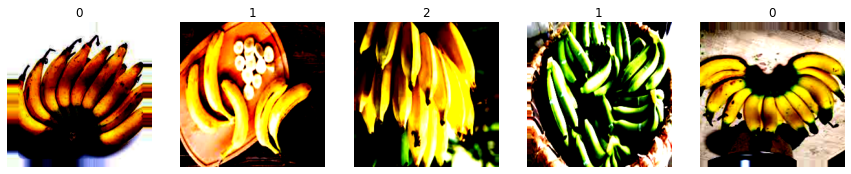

In [21]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( train_datagen.flow( x_train, y_train, batch_size=5, subset='validation' ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

===== Train batch no. 1/1 =====


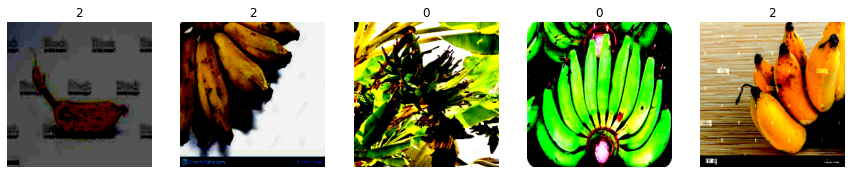

In [22]:
n_show = 1    # show 'n_show' batches of generated data (1 batch includes 5 images)

for b, (x_batch, y_batch) in enumerate( test_datagen.flow( x_test,y_test,batch_size=5 ) ):
  print( f"===== Train batch no. {b+1}/{n_show} =====" )
  plt.figure(figsize=(15,5))
  for i in range(5):
      plt.subplot(150 + 1 + i).set_title( y_batch[i] )                
      plt.imshow( x_batch[i])
      plt.axis( "off" )        # remove all tick marks 
  plt.show()

  if b+1 >= n_show:
    break

# **Train & Model Evaluate**

In [23]:
x = InceptionV3_extractor.output

#Add our custom layer(s) to the end of the existing model
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
new_outputs = tf.keras.layers.Dense(3, activation = 'softmax')(x)

#construct the main model
model = tf.keras.models.Model(inputs = InceptionV3_extractor.inputs, outputs = new_outputs)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [24]:
tf.keras.utils.plot_model(model, to_file = 'InceptionV3_Model.png', show_shapes = True, show_dtype = False, show_layer_names = True, dpi = 96)

In [25]:
model.compile( optimizer=tf.keras.optimizers.Adam(learning_rate=0.001) , 
                       loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                       metrics=['acc'] 
                     )

In [26]:
checkpoint_filepath = "bestweights.hdf5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint( filepath=checkpoint_filepath,
                                                                save_weights_only=True,
                                                                monitor='val_acc',
                                                                mode='max',
                                                                save_best_only=True)

In [27]:
history = model.fit(train_datagen.flow(x_train_xc ,y_train,batch_size=16,subset='training'),epochs = 1, verbose = 2,
                    callbacks=[model_checkpoint_callback],
                    validation_data=train_datagen.flow(x_train_xc ,y_train,subset='validation'))

19/19 - 57s - loss: 30.8417 - acc: 0.3980 - val_loss: 36.0923 - val_acc: 0.5317 - 57s/epoch - 3s/step


In [28]:
model.load_weights("bestweights.hdf5")
results = model.evaluate(test_datagen.flow(x_test_xc, y_test,batch_size=128,seed=123,shuffle=False))
print(f'{model.metrics_names}: {results}')

2/2 [==============================] - 19s 5s/step - loss: 36.8730 - acc: 0.5111
['loss', 'acc']: [36.872989654541016, 0.5111111402511597]


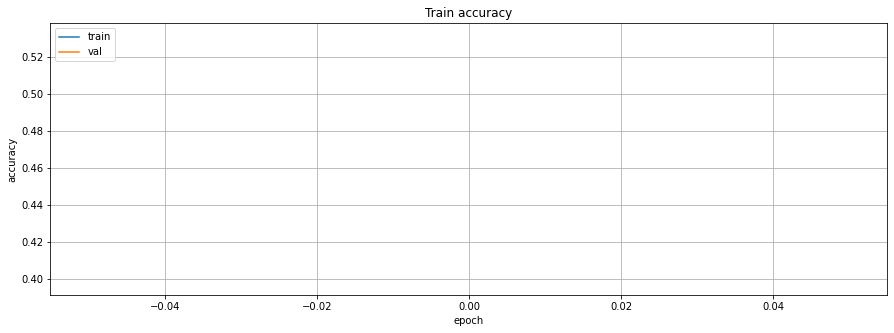

In [29]:
#Summarize history of accuracy
plt.figure(figsize = (15,5))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Train accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.grid()
plt.show()

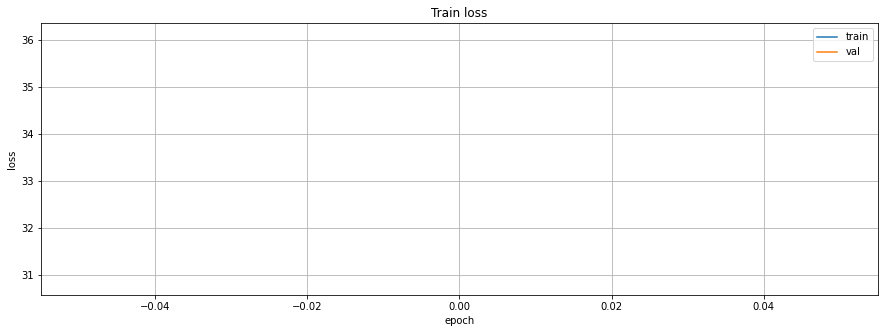

In [30]:
#Summarize history for loss
plt.figure(figsize = (15,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Train loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper right')
plt.grid()
plt.show()

1/1 [==============================] - 0s 167ms/step


[Text(32.99999999999999, 0.5, 'Actual'), Text(0.5, 15.0, 'Predict')]

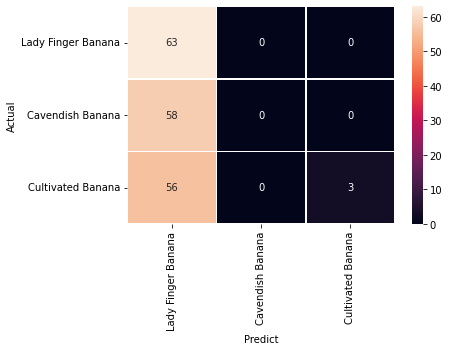

In [31]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
y_pred = []
for i in range(len(x_test_xc)):
  x_input = x_test_xc[i][np.newaxis, ...]
  y_pred.append(np.argmax(model.predict(x_input)))
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot = True, xticklabels = label, yticklabels = label, linewidth=.5, )
ax.set(xlabel='Predict',ylabel='Actual')

1/1 [==============================] - 0s 176ms/step


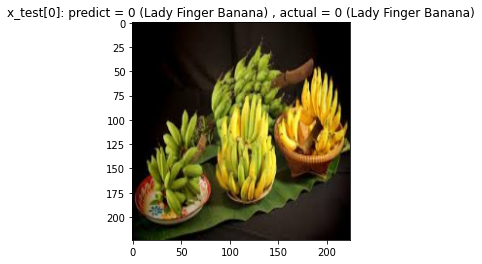

1/1 [==============================] - 0s 184ms/step


1/1 [==============================] - 0s 170ms/step


1/1 [==============================] - 0s 200ms/step


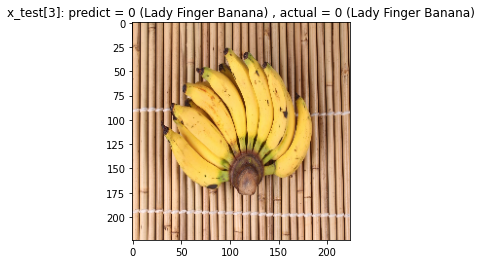

1/1 [==============================] - 0s 176ms/step


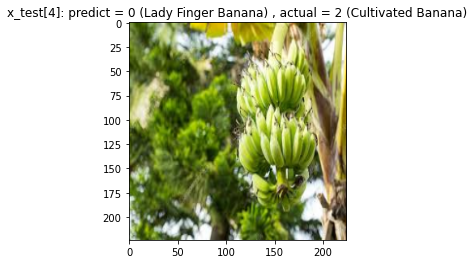

In [32]:
for i in range(5):
  y_pred = model.predict(x_test_xc[i].reshape(1,224,224,3))
  plt.imshow(x_test[i])
  plt.title(f'x_test[{i}]: predict = {np.argmax(y_pred)} ({label[np.argmax(y_pred)]}) , actual = {y_test[i]} ({label[int(y_test[i])]})')
  plt.show()

# **Grad-CAM**

1/1 [==============================] - 0s 169ms/step
Predicted: Cultivated Banana | Actual: Cultivated Banana 


1/1 [==============================] - 0s 171ms/step
Predicted: Lady Finger Banana | Actual: Cultivated Banana 


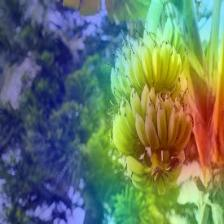

1/1 [==============================] - 0s 173ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


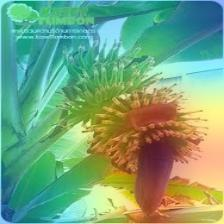

1/1 [==============================] - 0s 169ms/step
Predicted: Lady Finger Banana | Actual: Cavendish Banana 


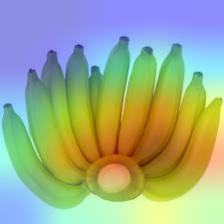

1/1 [==============================] - 0s 170ms/step
Predicted: Lady Finger Banana | Actual: Lady Finger Banana 


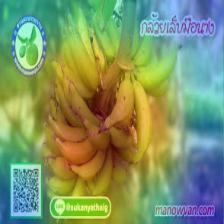

In [33]:
preprocess_input = keras.applications.inception_v3.preprocess_input
last_conv_layer_name = "mixed10"

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
          last_conv_layer_output, preds = grad_model(img_array)
          if pred_index is None:
              pred_index = tf.argmax(preds[0])
          class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
    
def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.8):
      img = img_path

      # Rescale heatmap to a range 0-255
      heatmap = np.uint8(255 * heatmap)

      # Use jet colormap to colorize heatmap
      jet = cmp.get_cmap("jet")

      # Use RGB values of the colormap
      jet_colors = jet(np.arange(256))[:, :3]
      jet_heatmap = jet_colors[heatmap]

      # Create an image with RGB colorized heatmap
      jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
      jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
      jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

      # Superimpose the heatmap on original image
      superimposed_img = jet_heatmap * alpha + img
      superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

      # Save the superimposed image
      superimposed_img.save(cam_path)

      # Display Grad CAM
      display(Image(cam_path))

for i in range(5):
  c= np.random.randint(0,180)
  img_path = x_test[c]
  img_array = preprocess_input(img_path)
  model.layers[-1].activation = None
  preds = model.predict(img_array.reshape(-1,224,224,3))
  print(f"Predicted: {label[np.argmax(preds)]} | Actual: {label[y_test[c]]} ")
  heatmap = make_gradcam_heatmap(img_array.reshape(1,224,224,3), model, last_conv_layer_name)
  save_and_display_gradcam(img_path, heatmap)